# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boing 747 or an Airbus A380

There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boing_vs_airbus/"
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1322


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54385 1.5079  1.5978 ]
Means with PIL :  [0.53277 0.56447 0.59706]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([650.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 672.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

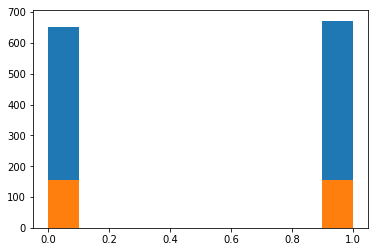

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


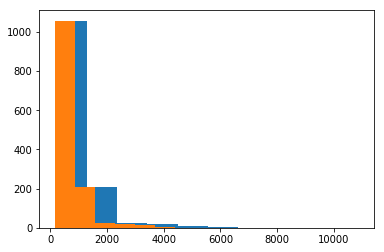

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  75., 120., 186.,  77., 102.,  33.,  60.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

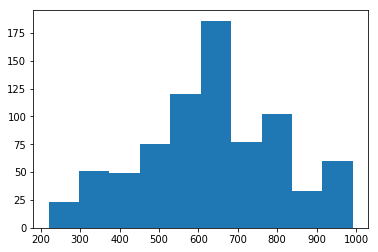

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data

### Guess learning rate

 91%|█████████ | 302/331 [00:22<00:02, 13.59it/s, loss=3.18] 

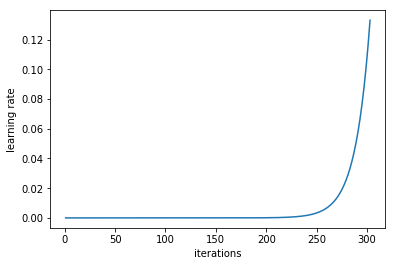

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

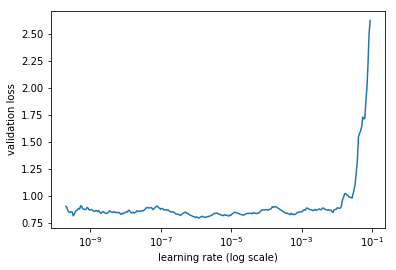

In [13]:
learn.sched.plot()

epoch      trn_loss   val_loss   accuracy                    
    0      0.873878   0.701487   0.519355  
    1      0.737926   0.684493   0.53871                     
    2      0.729174   0.714249   0.496774                    
    3      0.745242   0.696419   0.519355                    
    4      0.728175   0.690372   0.558065                    
    5      0.740742   0.698245   0.503226                    
    6      0.749192   0.702773   0.512903                    
    7      0.722365   0.694693   0.506452                    
    8      0.72082    0.689703   0.545161                    
    9      0.691952   0.687812   0.53871                     
    10     0.729589   0.691402   0.512903                    
    11     0.70054    0.686535   0.558065                    
    12     0.711638   0.689567   0.506452                    
    13     0.713907   0.691974   0.503226                    
    14     0.707741   0.691828   0.503226                    
    15     0.701754   0.69

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


array([[  0, 155],
       [  0, 155]])

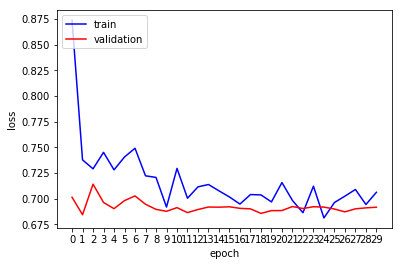

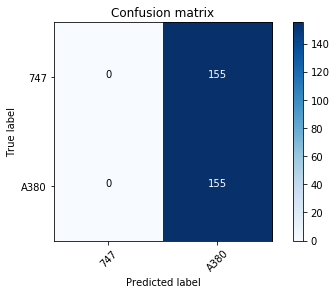

In [14]:
# F2 :  0.54 for lr=1e-4, image_size=128, batch_size=256, epoch=30
# F2 :  0.55 for lr=1e-5, image_size=128, batch_size=128, epoch=30, mais courbe erratique
# F2 :  0.49 for lr=1e-3, image_size=128, batch_size=256, epoch=30

lr=1e-4
image_size=128
batch_size=256
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                  
    0      0.795322   0.700717   0.590323  
    1      0.6689     0.661574   0.729032                  
    2      0.552887   0.685034   0.725806                  
    3      0.452826   0.617238   0.777419                  
    4      0.366926   0.751923   0.76129                   
    5      0.295843   0.58403    0.816129                  
    6      0.242837   0.624132   0.8                       
    7      0.198272   0.722432   0.812903                  
    8      0.166931   0.642116   0.848387                  
    9      0.141799   0.740201   0.803226                  
    10     0.121849   0.630813   0.822581                  
    11     0.103756   0.757527   0.8                       
    12     0.08695    0.841563   0.793548                   
    13     0.074554   0.736534   0.806452                   
    14     0.063072   0.762592   0.819355                   
    15     0.053438   0.870689   0.787097            

array([[116,  39],
       [ 22, 133]])

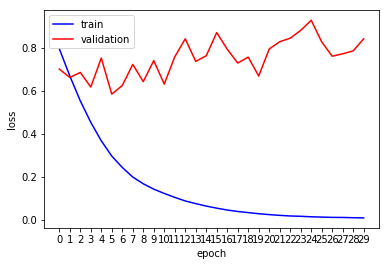

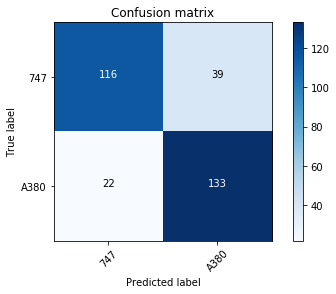

In [15]:
# F2 :  0.78 for image_size=128, batch_size=150, lr=1e-3, epoch=30
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2, epoch=30
# F2 :  0.77 for image_size=128, batch_size=150, lr=1e-4, epoch=30
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-2, epoch=30

image_size=128
batch_size=128
lr=1e-2
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Data augmentation
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

1322

'train/747/599.1162_1_hlr80459_2.jpg'

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


epoch      trn_loss   val_loss   accuracy                  
    0      0.897865   0.681648   0.554839  
    1      0.83969    0.68348    0.570968                  
    2      0.777893   0.608873   0.670968                  
    3      0.722185   0.595035   0.703226                  
    4      0.666216   0.53887    0.73871                   
    5      0.61343    0.52457    0.76129                   
    6      0.559595   0.530966   0.76129                   
    7      0.51313    0.493028   0.777419                  
    8      0.461317   0.473804   0.783871                  
    9      0.418897   0.48549    0.777419                  
    10     0.375962   0.487656   0.793548                  
    11     0.338711   0.523679   0.790323                  
    12     0.30709    0.496352   0.8                       
    13     0.276983   0.48815    0.816129                  
    14     0.24575    0.510922   0.796774                  
    15     0.222124   0.516932   0.793548               

array([[123,  32],
       [ 17, 138]])

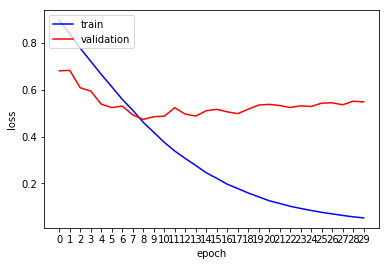

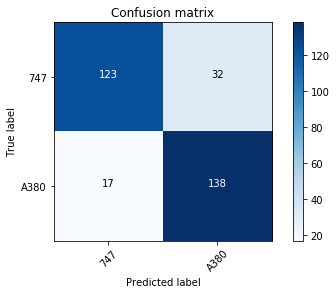

In [16]:
# F2 :  0.84 for image_size=128, batch_size=150, lr=1e-3, epoch=30, ps=0.5
# F2 :  0.73 for image_size=128, batch_size=150, lr=0.0001, epoch=30, ps=0.5
# F2 :  0.79 for image_size=128, batch_size=128, lr=1e-4, epoch=30
# F2 :  0.86 for image_size=128, batch_size=128, lr=1e-3, epoch=30

image_size=128
batch_size=128
lr=1e-3
epoch=30
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## Multiple size

epoch      trn_loss   val_loss   accuracy                
    0      0.873236   0.699642   0.587097  
After  1  epochs, the accuracy is  58.70 %
Saving to  resnext50_1_300_acc58.70_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.747298   0.589449   0.674194  
    1      0.694799   0.545088   0.725806                
    2      0.631048   0.530825   0.741935                
    3      0.573673   0.476388   0.754839                
    4      0.522854   0.470177   0.783871                
    5      0.479169   0.461213   0.793548                
    6      0.433472   0.448837   0.803226                
    7      0.393897   0.441933   0.806452                
    8      0.357286   0.440832   0.8                     
    9      0.325661   0.447302   0.796774                
After  11  epochs, the accuracy is  79.67 %
Saving to  resnext50_11_64_acc79.67_weights


epoch      trn_loss   val_loss   accuracy                
    0      0.175522   0.452099   0.829032  
    1      0.164044   0.465841   0.829032                
    2      0.156384   0.479523   0.822581                
    3      0.139599   0.495246   0.822581                
    4      0.130292   0.51387    0.822581                
    5      0.122047   0.522422   0.816129                
    6      0.117392   0.519491   0.822581                
    7      0.107644   0.522996   0.819355                
    8      0.099171   0.529256   0.816129                 
    9      0.094489   0.543965   0.809677                 
After  21  epochs, the accuracy is  80.96 %
Saving to  resnext50_21_128_acc80.96_weights


epoch      trn_loss   val_loss   accuracy                 
    0      0.060783   0.547884   0.809677  
    1      0.059495   0.560451   0.816129                 
    2      0.051764   0.590364   0.816129                 
    3      0.049528   0.609431   0.812903                 
    4      0.048974   0.61384    0.822581                 
    5      0.050518   0.630417   0.816129                 
    6      0.046392   0.630454   0.822581                 
    7      0.043449   0.624393   0.822581                 
    8      0.042261   0.617843   0.829032                 
After  30  epochs, the accuracy is  82.90 %
Saving to  resnext50_30_300_acc82.90_weights
[[135  20]                                   
 [ 21 134]]
Precision :  0.8709677419354839
Recall :  0.8653846153846154
F1 :  0.8681672025723471
F2 :  0.8664955070603337


array([[135,  20],
       [ 21, 134]])

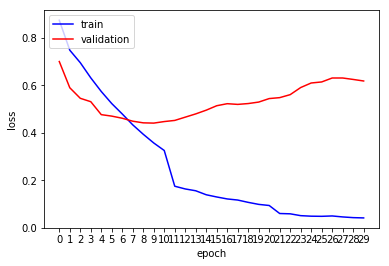

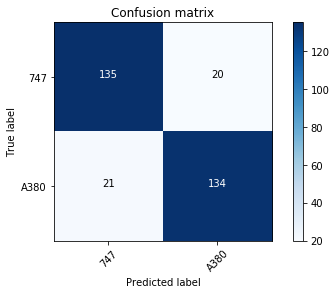

In [17]:
# F2 :  0.67 for learning_rate = 1e-4, dropout = [0.25,0.5], image_size = 128, batch_size = 150
# F2 :  0.62 pour dropout =[0.25,0.5] et learning_rate = 1e-3
# F2 :  0.79 pour dropout = 0.5 et learning_rate = 1e-3
# F2 :  0.85 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
# F2 :  0.86 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150


learning_rate = 1e-2
dropout = 0.5
image_size = 128
batch_size = 150

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 9],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

## SGDR - Learning rate anealing

SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
    cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

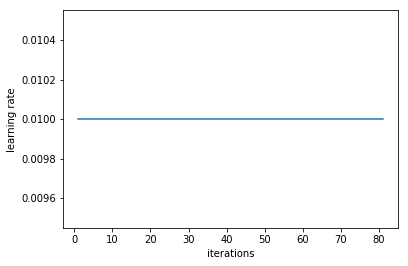

In [18]:
learn.sched.plot_lr()

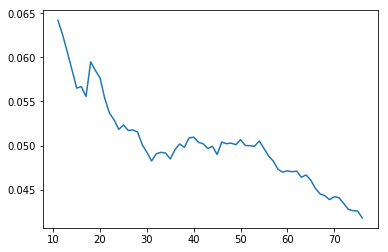

In [19]:
learn.sched.plot_loss()

Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.927052   0.823599   0.490323  
After  1  epochs, the accuracy is  49.03 %
Saving to  resnext50_1_300_acc49.03_weights
Hyperparameters : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.867113   0.749602   0.529032  
    1      0.782153   0.732549   0.548387                    
    2      0.757656   0.712228   0.587097                    
    3      0.7138     0.726646   0.590323                    
    4      0.733309   0.617438   0.645161                    
    5      0.66473    0.598729   0.683871                    
    6      0.678014   0.585667   0.706452                    
    7      0.670831   0.559058   0.712903                    
    8      0.658902   0.547948   0.719355                    
    9      0.577431   0.532923   0.716129                    
After  11  epochs, the accuracy is  71.61 %
Saving to  resnext50_11_64_acc71.61_weights
Hyperparameters : Batch size= 150  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.607954   0.542751   0.741935  
    1      0.605879   0.535633   0.741935                    
    2      0.580047   0.516818   0.732258                    
    3      0.583068   0.503483   0.76129                     
    4      0.555762   0.524531   0.754839                    
    5      0.60765    0.519249   0.76129                     
    6      0.523533   0.499815   0.767742                    
    7      0.565407   0.496656   0.780645                    
    8      0.540897   0.505793   0.770968                    
    9      0.547778   0.486088   0.774194                    
After  21  epochs, the accuracy is  77.41 %
Saving to  resnext50_21_128_acc77.41_weights
Hyperparameters : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.0001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.515101   0.490644   0.754839  
    1      0.515451   0.478732   0.783871                    
    2      0.56312    0.468654   0.76129                     
    3      0.507389   0.453976   0.758065                    
    4      0.517166   0.479388   0.767742                    
    5      0.508668   0.491886   0.764516                    
    6      0.530767   0.464546   0.790323                    
    7      0.533638   0.462802   0.764516                    
    8      0.513442   0.454993   0.787097                    
    9      0.481568   0.448952   0.774194                    
After  31  epochs, the accuracy is  77.41 %
Saving to  resnext50_31_300_acc77.41_weights


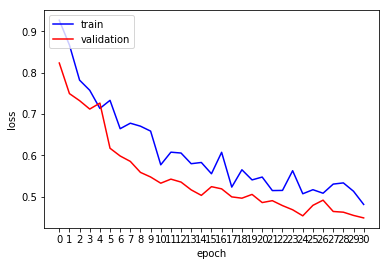

In [20]:
# F2 :  0.80 pour [0.25,0.5] et 1e-4
# F2 :  0.76 pour dropout = 0.5 et learning_rate = 1e-4
# F2 :  0.76  for learning_rate = 1e-3, dropout = [0.25,0.5], lr=np.array([learning_rate/100,learning_rate/10,learning_rate]
# F2 :  0.49 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.74 for learning_rate = 1e-4, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.53 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]


learning_rate = 1e-4
lr=np.array([learning_rate/100,learning_rate/10,learning_rate])
dropout = [0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]
#    [256, 128, 3],
#    [123, 300, 3],
#    [64, 600, 3],
#    [123, 300, 4],
#    [256, 128, 2],
#    [123, 300, 2],
#    [64, 600, 3],
#    [123, 400, 2]
for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[132  23]                                   
 [ 30 125]]
Precision :  0.8516129032258064
Recall :  0.8148148148148148
F1 :  0.8328075709779179
F2 :  0.821917808219178


array([[132,  23],
       [ 30, 125]])

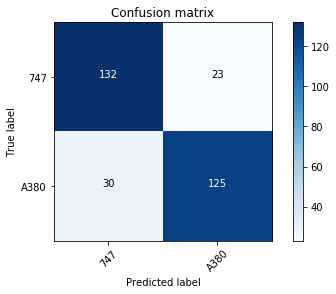

In [21]:
plot_the_confusion_matrix()

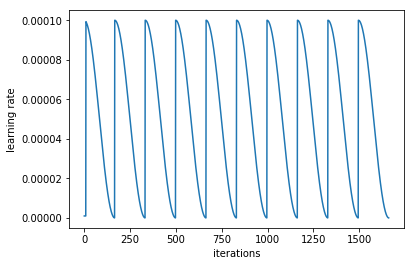

In [22]:
learn.sched.plot_lr()

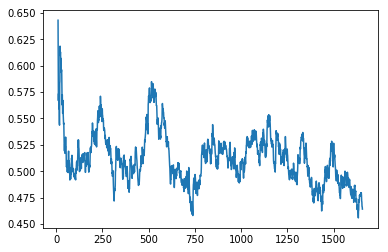

In [23]:
learn.sched.plot_loss()

## Variable cycle length

In [24]:
learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = 0.5 # [0.25,0.5]
# F2 :  0.66 pour learning_rate = 1e-3 et dropout = [0.25,0.5]
# F2 :  0.85 for learning_rate = 1e-3, dropout = [0.25,0.5]
# F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5

aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [123, 300, 3],
    [512, 64, 4],
    [256, 128, 3],
    [123, 400, 2]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.697935   0.698329   0.616129  
    1      0.739952   0.709906   0.603226                    
    2      0.778816   0.693813   0.590323                    
    3      0.766412   0.667394   0.590323                    
    4      0.704557   0.630417   0.648387                    
    5      0.668227   0.631244   0.629032                    
    6      0.630902   0.607281   0.664516                    
After  7  epochs, the accuracy is  66.45 %
Saving to  resnext50_7_300_acc66.45_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.628584   0.597109   0.670968  
    1      0.637104   0.605616   0.66129                     
    2      0.56136    0.574899   0.709677                    
    3      0.633155   0.598131   0.7                         
    4      0.560407   0.605001   0.690323                    
    5      0.520804   0.565934   0.703226                    
    6      0.519842   0.58383    0.703226                    
    7      0.53111    0.567278   0.709677                    
    8      0.459855   0.523677   0.735484                    
    9      0.427776   0.579749   0.709677                    
    10     0.410256   0.596371   0.716129                    
    11     0.445964   0.505227   0.754839                    
    12     0.393695   0.506345   0.751613                    
    13     0.400815   0.519018   0.745161                    
    14     0.403056   0.526786   0.735484                    
After  22  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.382838   0.516952   0.767742  
    1      0.411369   0.713864   0.670968                    
    2      0.511801   0.60519    0.680645                    
    3      0.470199   0.5514     0.748387                    
    4      0.480908   0.517489   0.716129                    
    5      0.45706    0.537179   0.732258                    
    6      0.468495   0.539967   0.712903                    
After  29  epochs, the accuracy is  71.29 %
Saving to  resnext50_29_128_acc71.29_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 2  Images sizes= 400


epoch      trn_loss   val_loss   accuracy                    
    0      0.416966   0.521951   0.729032  
    1      0.422256   0.517249   0.735484                    
    2      0.368338   0.515083   0.751613                    
After  32  epochs, the accuracy is  75.16 %
Saving to  resnext50_32_400_acc75.16_weights


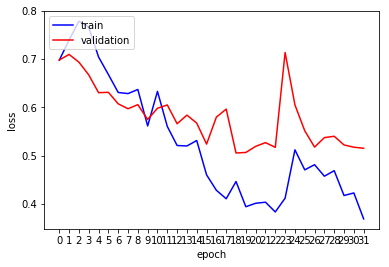

In [25]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


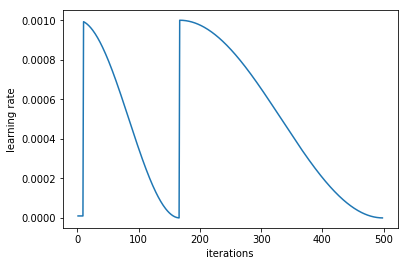

In [26]:
learn.sched.plot_lr()

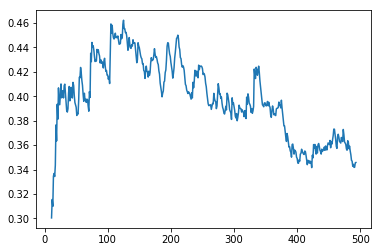

In [27]:
learn.sched.plot_loss()

[[114  41]                                   
 [ 23 132]]
Precision :  0.7354838709677419
Recall :  0.8321167883211679
F1 :  0.7808219178082192
F2 :  0.8108108108108107


array([[114,  41],
       [ 23, 132]])

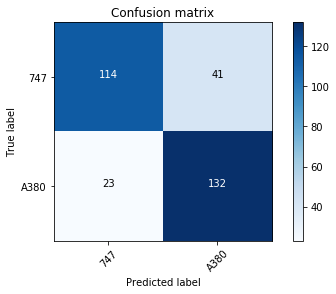

In [28]:
plot_the_confusion_matrix()

# More epochs

In [29]:
# resnext50 results :
    # F2 :  0.84 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
    # F2 :  0.69 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]


learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = [0.25,0.5]
arch=resnet34
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4],
    [256, 128, 3],
    [123, 300, 3],
    [64, 600, 3]

#     [123, 300, 3],
#     [512, 64, 4],
#     [256, 128, 3],
#     [64, 600, 3]
    
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3]
#     [123, 400, 6]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)



Hyperparameters for  resnet34  : Batch size= 512  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.802318   0.668567   0.574194  
    1      0.761067   0.707351   0.519355                    
    2      0.774489   0.688701   0.577419                    
    3      0.728445   0.714935   0.535484                    
    4      0.690063   0.687439   0.587097                    
    5      0.697512   0.675493   0.574194                    
    6      0.674816   0.677085   0.590323                    
    7      0.725418   0.916686   0.493548                    
    8      0.731205   0.703105   0.574194                    
    9      0.74158    0.674307   0.567742                    
    10     0.705478   0.674934   0.56129                     
    11     0.699784   0.683699   0.587097                    
    12     0.684185   0.676711   0.56129                     
    13     0.676011   0.690495   0.545161                    
    14     0.697446   0.690512   0.522581                    
After  15  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.71102    0.673714   0.554839  
    1      0.692516   0.66539    0.587097                    
    2      0.697377   0.671435   0.558065                    
    3      0.705848   0.696578   0.593548                    
    4      0.718028   0.71393    0.496774                    
    5      0.711475   0.689979   0.551613                    
    6      0.718381   0.680824   0.577419                    
After  22  epochs, the accuracy is  57.74 %
Saving to  resnet34_22_128_acc57.74_weights
Hyperparameters for  resnet34  : Batch size= 123  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.708529   0.697194   0.541935  
    1      0.707393   0.674504   0.587097                    
    2      0.701257   0.681574   0.554839                    
    3      0.71754    0.692635   0.554839                    
    4      0.730987   0.682296   0.587097                    
    5      0.720019   0.677173   0.577419                    
    6      0.712629   0.681195   0.56129                     
After  29  epochs, the accuracy is  56.12 %
Saving to  resnet34_29_300_acc56.12_weights
Hyperparameters for  resnet34  : Batch size= 64  Drop out= [0.25, 0.5]  Learning rate= 0.001  Cycle= 3  Images sizes= 600


epoch      trn_loss   val_loss   accuracy                    
    0      0.69385    0.654644   0.603226  
    1      0.696668   0.665718   0.596774                    
    2      0.687096   0.663091   0.574194                    
    3      0.726031   0.705981   0.548387                    
    4      0.698016   0.67773    0.583871                    
    5      0.67802    0.665777   0.590323                    
    6      0.658732   0.669812   0.603226                    
After  36  epochs, the accuracy is  60.32 %
Saving to  resnet34_36_600_acc60.32_weights


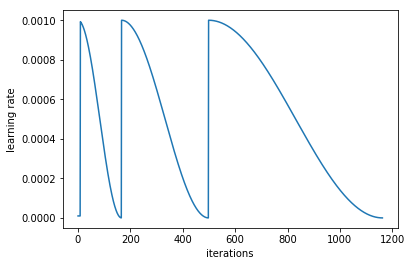

In [30]:
learn.sched.plot_lr()

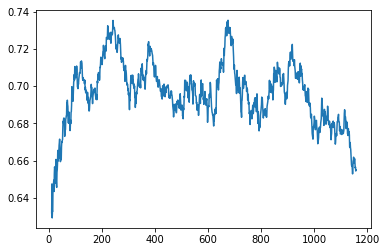

In [31]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[ 68  87]                                   
 [ 36 119]]
Precision :  0.43870967741935485
Recall :  0.6538461538461539
F1 :  0.525096525096525
F2 :  0.5954465849387041


array([[ 68,  87],
       [ 36, 119]])

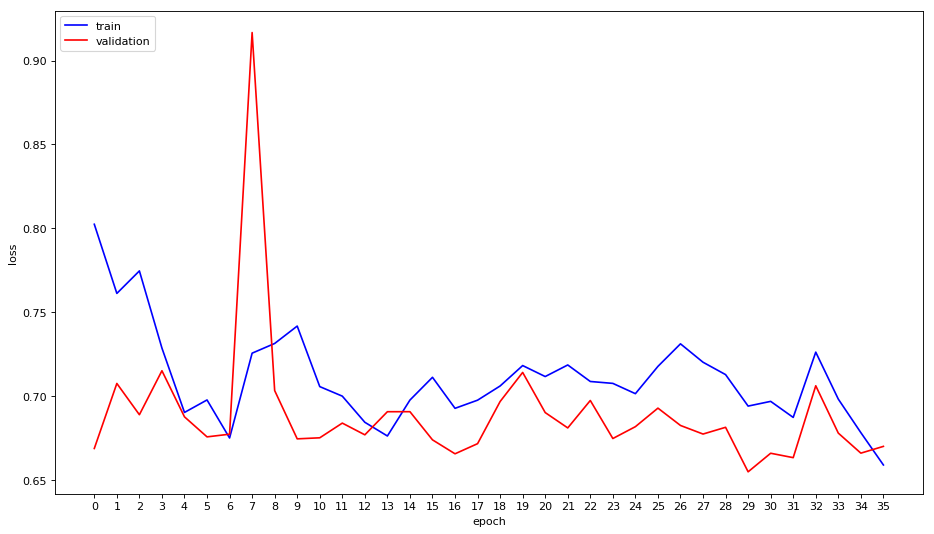

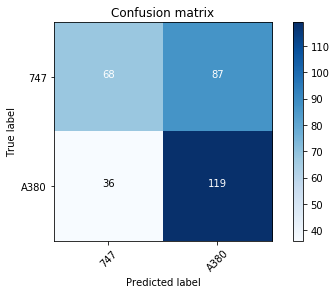

In [32]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [33]:
loadmodel=False
#loadmodel=True
if loadmodel==True:
    data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, 64), bs=123, num_workers=num_cpus())
    data = get_data(64, 64) 
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
    learn.load("resnext50_32_400_acc95.01_weights")
    learn.freeze()
    vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    plot_ep_vals(global_results)
    print("Model chargé")

# Prediction et visualisation

[[ 73  82]                                   
 [ 33 122]]
Precision :  0.47096774193548385
Recall :  0.6886792452830188
F1 :  0.5593869731800766
F2 :  0.6303972366148531


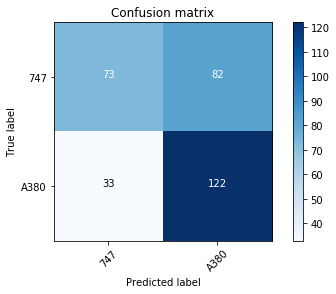

In [34]:
cm = plot_the_confusion_matrix()

In [35]:
?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [36]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.47096774193548385
recall :  0.6886792452830188
F1 :  0.5593869731800766
F2 :  0.6303972366148531


In [37]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 10

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['747', 'A380']

(310, 2)

Most incorrect 747


ValueError: num must be 1 <= num <= 8, not 9

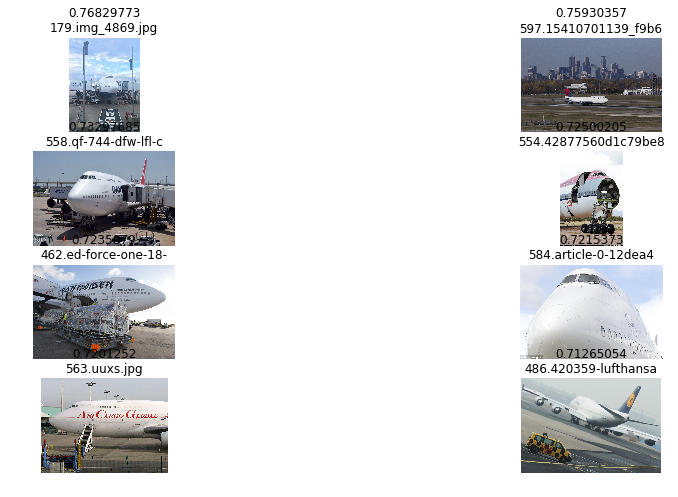

In [38]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

In [ ]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

In [ ]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
# Taille de batch faible pour trouver le bon learning rate
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

#next(iter(data.aug_dl)) Retourne batch_size images de taille sz*sz
len(data.trn_ds.fnames)
# data.trn_ds contient le dataset de test
data.trn_ds.fnames[100]

size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [ ]:
plt.hist(data.trn_y)

In [ ]:
plt.hist(row_sz);
plt.hist(col_sz);
plt.hist(row_sz[row_sz < 1000])

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.